In [1]:
import os
os.chdir("..")

In [54]:
import numpy as np

from classifier_3D.utils.ply_file import read_ply
from classifier_3D.utils.path import get_data_path

file_path = get_data_path("MiniLille1.ply", True)

cloud, _ = read_ply(file_path)
points = np.vstack((cloud["x"], cloud["y"], cloud["z"])).T.astype(np.float32)

[ 0.22020824 -1.04610658 -0.72931582]


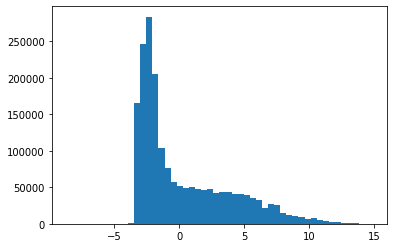

0.27068418
-0.732288384437561
[ 0.22020824 -1.0461066  -0.73228836]


In [73]:
import matplotlib.pyplot as plt

bin_count, bin_boxes, _ = plt.hist(points[:, -1], bins=50)
plt.show()
print(points[:, -1].mean())

z_center = (bin_boxes[np.argmax(bin_count) + 1] + bin_boxes[np.argmax(bin_count) + 2]) / 2 + 1.1
print(z_center)

center_of_projection = points.mean(axis=0)
center_of_projection[-1] = z_center
print(center_of_projection)

centered_points = points - center_of_projection

In [74]:
proj_fov_up = 3.0
proj_fov_down = -25.0

proj_W = 1024
proj_H = 64

In [75]:
fov_up = proj_fov_up / 180.0 * np.pi      # field of view up in rad
fov_down = proj_fov_down / 180.0 * np.pi  # field of view down in rad
fov = abs(fov_down) + abs(fov_up)  # get field of view total in rad

# get depth of all points
depth = np.linalg.norm(centered_points, axis=1)

# get scan components
scan_x = centered_points[:, 0]
scan_y = centered_points[:, 1]
scan_z = centered_points[:, 2]

# get angles of all points
yaw = -np.arctan2(scan_y, scan_x)
pitch = np.arcsin(scan_z / depth)

# get projections in image coords
proj_x = 0.5 * (yaw / np.pi + 1.0)          # in [0.0, 1.0]
proj_y = 1.0 - (pitch + abs(fov_down)) / fov        # in [0.0, 1.0]

# scale to image size using angular resolution
proj_x *= proj_W                              # in [0.0, W]
proj_y *= proj_H                              # in [0.0, H]

# round and clamp for use as index
proj_x = np.floor(proj_x)
proj_x = np.minimum(proj_W - 1, proj_x)
proj_x = np.maximum(0, proj_x).astype(np.int32)   # in [0,W-1]
proj_x_copy = np.copy(proj_x)  # store a copy in orig order

proj_y = np.floor(proj_y)
proj_y = np.minimum(proj_H - 1, proj_y)
proj_y = np.maximum(0, proj_y).astype(np.int32)   # in [0,H-1]
proj_y_copy = np.copy(proj_y)  # stope a copy in original order

# copy of depth in original order
unproj_range = np.copy(depth)

# order in decreasing depth
indices = np.arange(depth.shape[0])
order = np.argsort(depth)[::-1]
depth = depth[order]
indices = indices[order]
points_ = centered_points[order]
proj_y = proj_y[order]
proj_x = proj_x[order]

# assing to images
proj_range = np.full((proj_H, proj_W), -1, dtype=np.float32)
proj_range[proj_y, proj_x] = depth
proj_xyz = np.full((proj_H, proj_W, 3), -1, dtype=np.float32)
proj_xyz[proj_y, proj_x] = points  
proj_idx = np.full((proj_H, proj_W), -1, dtype=np.int32)
proj_idx[proj_y, proj_x] = indices
proj_mask = (proj_idx > 0).astype(np.int32)

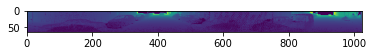

In [76]:
plt.imshow(proj_range)

In [ ]:
### Put the projection in the direction of the road :)